# Face recognition

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import numpy as np
from PIL import Image
import math

In [2]:
mnist_transforms = T.Compose(
    [
        T.Resize((32, 32)),
        T.ToTensor(),
    ]
)

train_dataset = MNIST('mnist', train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST('mnist', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.52MB/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
def train(model):
    model.train()

    train_loss = 0

    for x, _ in tqdm(train_loader, desc='Train'): #no y as we don't need Dataset labeling
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, x)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

In [4]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x, _ in tqdm(loader, desc='Evaluation'): #no y as we don't need Dataset labeling
        x = x.to(device)

        output = model(x)

        loss = loss_fn(output, x)

        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss

In [5]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [6]:
from torchvision.utils import make_grid


@torch.inference_mode()
def visualize(model, xs):
    model.eval()

    to_pil = T.ToPILImage()

    outputs = model(xs.to(device)).cpu()
    
    plt.figure(figsize=(20, 4))
    
    plt.imshow(
        to_pil(
            torch.cat(
                (
                    make_grid(xs[:10], nrow=10, pad_value=1),#pad_value = 1 - white
                    make_grid(outputs[:10], nrow=10, pad_value=1)
                ),
                dim=1
            )
        )
    )
    
    plt.axis('off')

    plt.show()

In [7]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)
        
        visualize(model, next(iter(valid_loader))[0])

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__()
        self.upsample = upsample

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=1,
            bias=False
        )
        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        return self.act(self.norm(self.conv(x)))


class AutoEncoder(nn.Module):
    def __init__(self, in_channels: int, base_block: nn.Module = Block, base_size: int = 16, num_blocks: int = 4):
        super().__init__()

        self.base_size = base_size

        # encoder creation

        encoder_blocks = []

        for i in range(num_blocks):
            encoder_blocks.append(
                base_block(
                    in_channels=base_size if i else in_channels,
                    out_channels=base_size,
                    kernel_size=3,
                    stride=2 ### decreasing size of image 2 times with each block. image will be size 4x4 after 4 blocks
                )
            )

        encoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=base_size,
                kernel_size=3
            ).conv #convolutional 
        )

        self.encoder = nn.Sequential(*encoder_blocks)  # N -> N // (2 ** num_blocks)

        # decoder creation

        decoder_blocks = []

        for i in range(num_blocks):
            decoder_blocks.append(
                base_block(
                    in_channels=base_size,
                    out_channels=base_size,
                    kernel_size=3,
                    upsample=True
                )
            )

        decoder_blocks.append(
            base_block(
                in_channels=base_size,
                out_channels=in_channels,
                kernel_size=3
            ).conv #convolutional 
        )
        decoder_blocks.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_blocks)  # N // (2 ** num_blocks) -> N

        self.flatten = nn.Flatten() ### flatten is for vector

    def forward(self, x):
        # x.shape = [bs (batch size), in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

    @torch.inference_mode()
    def encode(self, x):
        # x.shape = [bs, in_channels, N, N]
        return self.flatten(self.encoder(x)) # output.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2] 

    @torch.inference_mode()
    def decode(self, x):
        # x.shape = [bs, base_size * N ** 2 / (2 ** num_blocks) ** 2]
        latent_size = int(math.sqrt(x.shape[1] // self.base_size))

        return self.decoder(x.view(-1, self.base_size, latent_size, latent_size))  # output.shape = [bs, in_channels, N, N]

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.MSELoss()

cuda:0
Tesla P100-PCIE-16GB


In [10]:
class DenoisingBlock(Block):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, upsample: bool = False):
        super().__init__(in_channels, out_channels, kernel_size, stride, upsample)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        if self.upsample: ### if we have upsample
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False, recompute_scale_factor=False)

        if self.training: ### if we are training nn
            x = x + torch.randn_like(x) * 0.05

        return self.act(self.norm(self.conv(x)))


class DenoisingAutoEncoder(AutoEncoder):
    def __init__(self, in_channels: int, base_block: nn.Module = DenoisingBlock, base_size: int = 16, num_blocks: int = 4):
        super().__init__(in_channels, base_block, base_size, num_blocks)

    def forward(self, x):
        if self.training:
            x = torch.clip(x + torch.randn_like(x) * 0.1, min=0, max=1) ### adding noise,keeping image within 0 - 1

        # x.shape = [bs, in_channels, N, N]
        x = self.encoder(x)
        # x.shape = [bs, base_size, N // (2 ** num_blocks), N // (2 ** num_blocks)]
        x = self.decoder(x)
        # x.shape = [bs, in_channels, N, N]

        return x

In [11]:
de_model = DenoisingAutoEncoder(in_channels=1).to(device)

optimizer = Adam(de_model.parameters(), lr=1e-3)

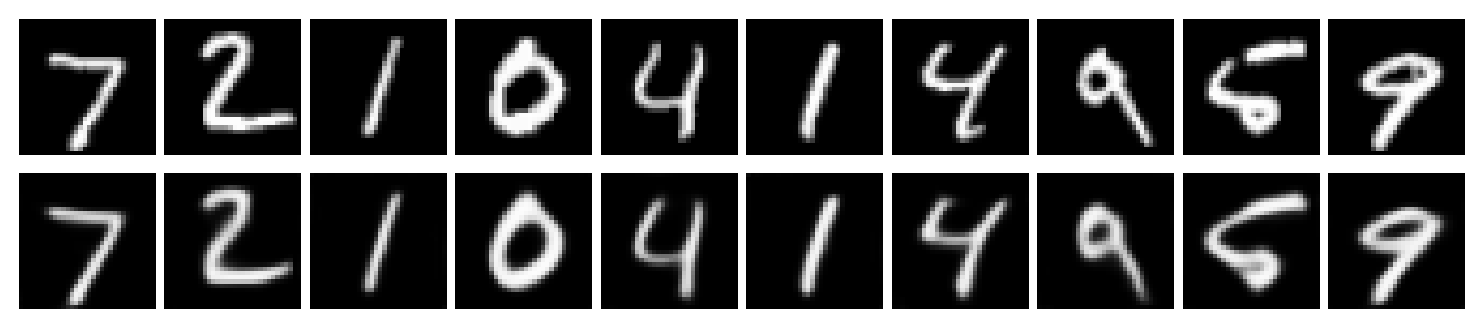

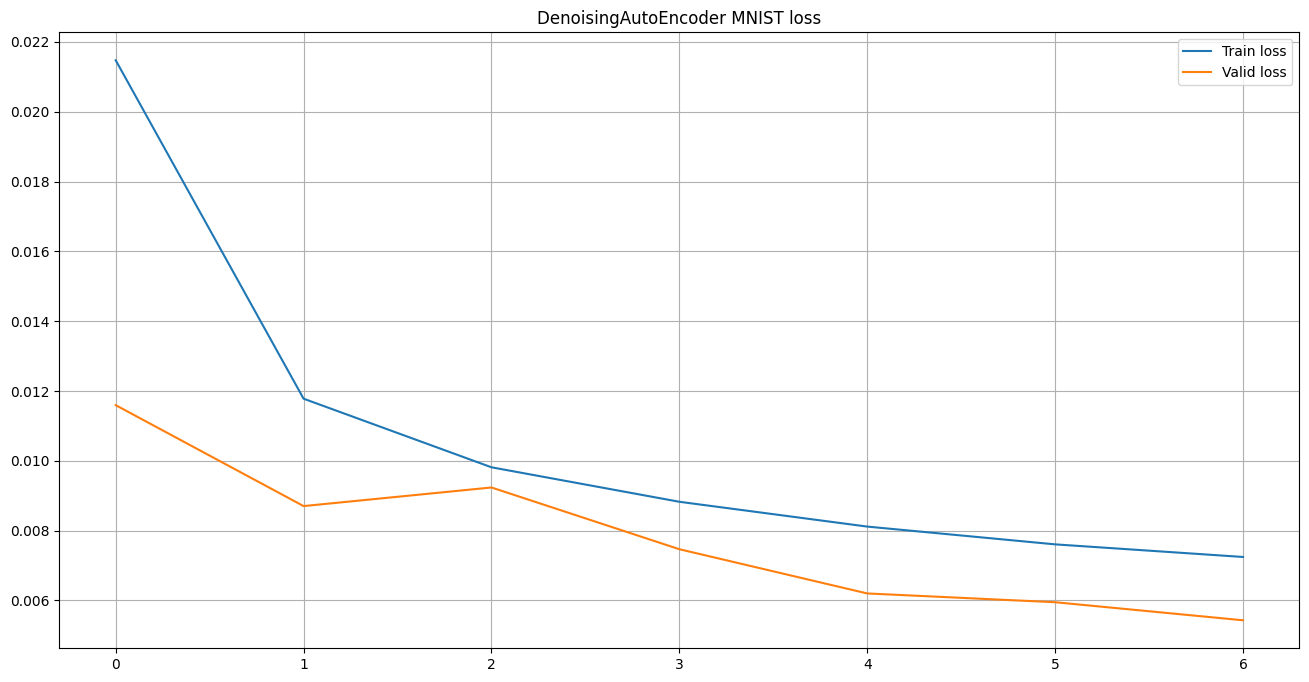

In [12]:
whole_train_valid_cycle(de_model, 7, 'DenoisingAutoEncoder MNIST')

In [13]:
@torch.inference_mode()
def get_interpolation(model, x1, x2):
    z1 = model.encode(x1.unsqueeze(0).to(device))
    z2 = model.encode(x2.unsqueeze(0).to(device))

    weights = torch.linspace(start=0, end=1, steps=7).unsqueeze(1).to(device)

    zs = z2 * weights + z1 * (1 - weights) ### zs is interpolation

    images = model.decode(zs)

    plt.figure(figsize=(14, 4))

    plt.imshow(T.ToPILImage()(make_grid(images, nrow=7, pad_value=1)))

    plt.axis('off')

    plt.show()

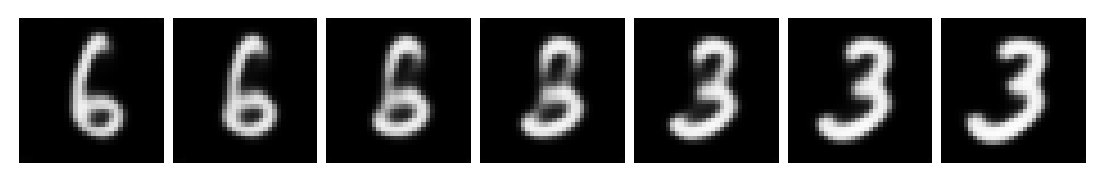

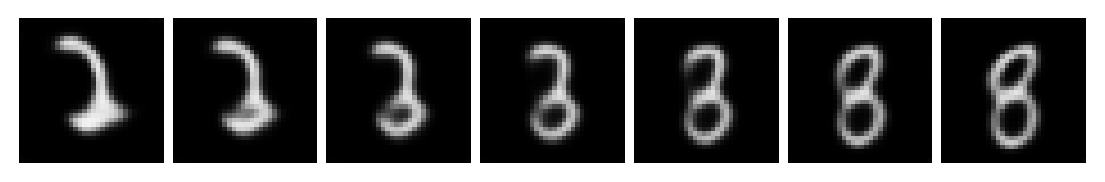

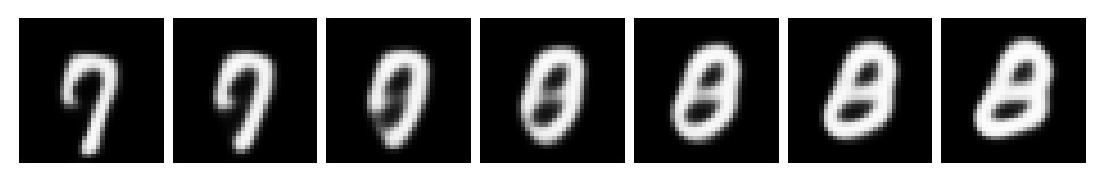

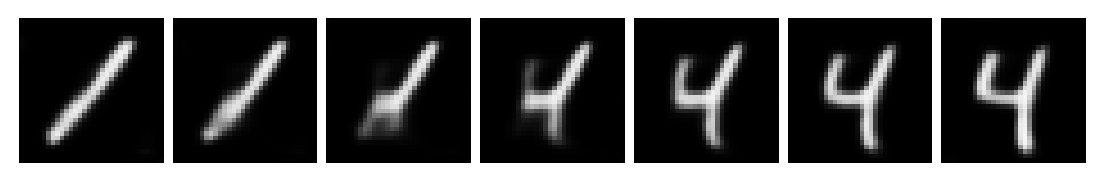

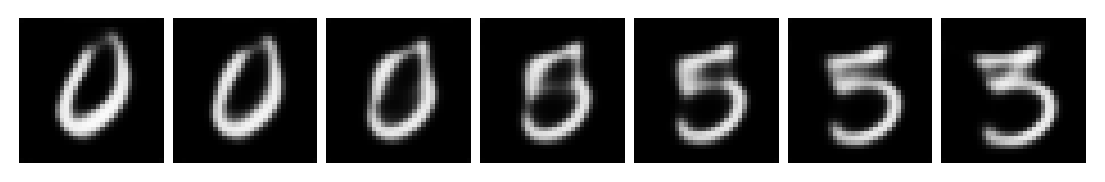

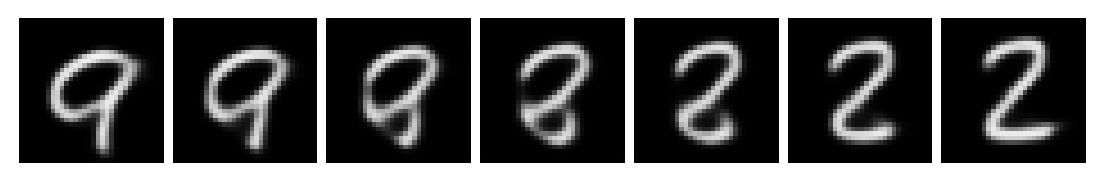

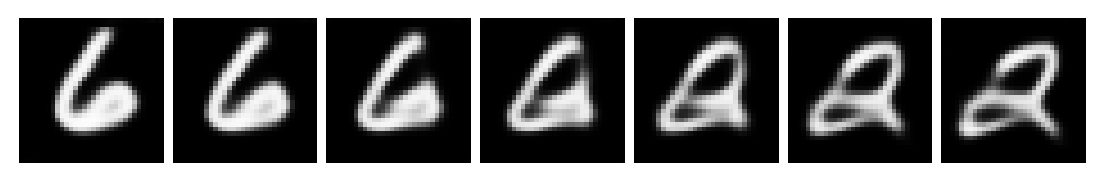

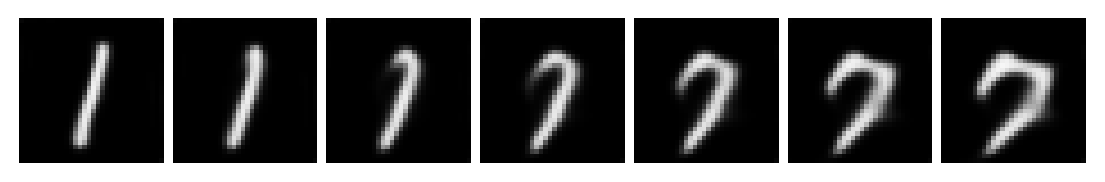

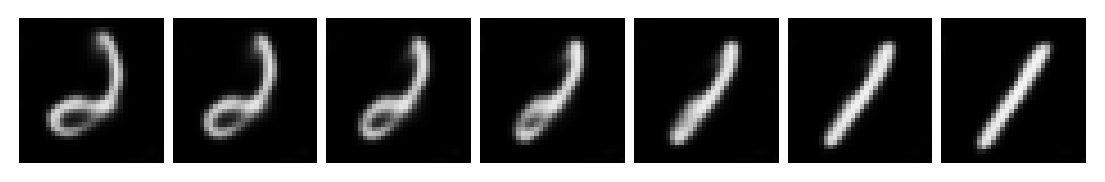

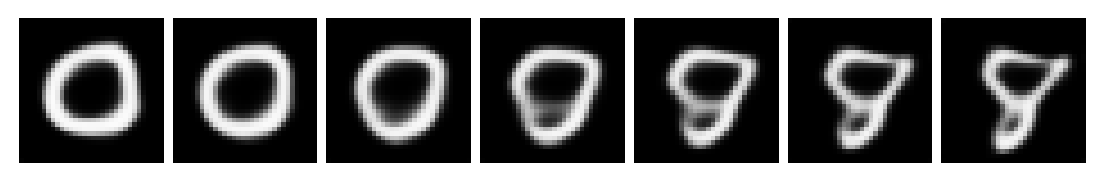

In [14]:
for _ in range(10):
    idx1, idx2 = np.random.randint(len(valid_dataset), size=2)
    get_interpolation(de_model, valid_dataset[idx1][0], valid_dataset[idx2][0])

In [15]:
@torch.inference_mode()
def get_latent_labels(model, loader, count: int=None):
    model.eval()
    
    total = 0
    
    latent = []
    labels = []
    
    for x, y in loader:
        z = model.encode(x.to(device)).cpu()
        
        latent.append(z)
        labels.append(y)
        
        total += y.shape[0]
        
        if count is not None and total >= count:
            break
            
    latent = torch.cat(latent)[:count].numpy()
    labels = torch.cat(labels)[:count].numpy()
    
    return latent, labels

In [16]:
x, y = get_latent_labels(de_model, train_loader, 1000)

In [17]:
x.shape, y.shape

((1000, 64), (1000,))

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
clf = RandomForestClassifier().fit(x, y)

In [20]:
x_valid, y_valid = get_latent_labels(de_model, valid_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
x_valid.shape, y_valid.shape

((10000, 64), (10000,))

In [22]:
#!g1.1
(clf.predict(x_valid) == y_valid).mean()

0.9214

In [28]:
def save_embeddings(x_train, y_train, x_valid, y_valid):
    assert x_train.shape[0] == 1000
    assert x_valid.shape[0] == 10000
    
    assert y_train.shape[0] == 1000
    assert y_valid.shape[0] == 10000

    torch.save(
        {
            'x_train': x_train,
            'y_train': y_train,
            'x_valid': x_valid,
            'y_valid': y_valid
        },
        'embeddings.pt'
    )

In [29]:
save_embeddings(x,y,x_valid,y_valid)